##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with a CNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c09_forecasting_with_cnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c09_forecasting_with_cnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [21]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    """기간 동안 동일한 패턴 반복"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    print("seq2seq_window_dataset function")
    series = tf.expand_dims(series, axis=-1)
    print("="*50)
    print(series)
    print("="*50)
    ds = tf.data.Dataset.from_tensor_slices(series)
    print("="*50)
    print(ds)
    print("="*50)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    print("="*50)
    print(ds)
    print("="*50)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    print("="*50)
    print(ds)
    print("="*50)
    ds = ds.shuffle(shuffle_buffer)
    print("="*50)
    print(ds)
    print("="*50)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    print("="*50)
    print(ds)
    print("="*50)
    print(ds.batch(batch_size).prefetch(1))
    print("="*50)
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

[   0    1    2 ... 1458 1459 1460] [ 52.48357077  49.35275206  53.31473872 ...  91.37325376  88.32382529
 122.30772008]


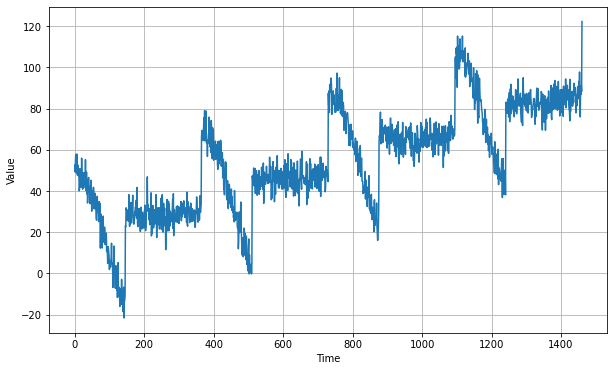

In [22]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise
print(time, series)
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [26]:
print(len(series), len(time))


1461 1461


In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [20]:
print(time_train.shape, x_train.shape, time_valid.shape, x_valid.shape)
x_train

(1000,) (1000,) (461,) (461,)


array([ 52.48357077,  49.35275206,  53.31473872,  57.71182193,
        48.93444534,  48.93124221,  57.98289687,  53.89712254,
        47.67392616,  52.68370684,  47.59171581,  47.50637547,
        50.95941456,  40.08618007,  40.91941291,  46.6124749 ,
        44.2282075 ,  50.7206442 ,  44.45498265,  41.76799162,
        55.98093655,  47.33583647,  48.60329748,  40.93184102,
        45.11265791,  48.15731844,  41.60509948,  48.98523395,
        43.83963141,  45.10993464,  43.27504251,  55.24983156,
        45.61561472,  40.07910685,  49.15495543,  38.60270198,
        45.40616172,  34.20876785,  37.00193411,  44.25351033,
        46.57859628,  43.35101175,  41.51481464,  40.17753568,
        33.87169104,  37.2377144 ,  38.09790511,  45.24254666,
        41.22268301,  30.22901514,  40.19637968,  36.17456548,
        34.23181292,  40.18383749,  41.78223419,  40.77832754,
        31.41360409,  33.54463559,  36.22142998,  38.91083398,
        31.0989853 ,  32.02223667,  26.8686348 ,  25.86

## Preprocessing With 1D-Convolutional Layers

In [28]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)


seq2seq_window_dataset function
tf.Tensor(
[[ 52.48357077]
 [ 49.35275206]
 [ 53.31473872]
 [ 57.71182193]
 [ 48.93444534]
 [ 48.93124221]
 [ 57.98289687]
 [ 53.89712254]
 [ 47.67392616]
 [ 52.68370684]
 [ 47.59171581]
 [ 47.50637547]
 [ 50.95941456]
 [ 40.08618007]
 [ 40.91941291]
 [ 46.6124749 ]
 [ 44.2282075 ]
 [ 50.7206442 ]
 [ 44.45498265]
 [ 41.76799162]
 [ 55.98093655]
 [ 47.33583647]
 [ 48.60329748]
 [ 40.93184102]
 [ 45.11265791]
 [ 48.15731844]
 [ 41.60509948]
 [ 48.98523395]
 [ 43.83963141]
 [ 45.10993464]
 [ 43.27504251]
 [ 55.24983156]
 [ 45.61561472]
 [ 40.07910685]
 [ 49.15495543]
 [ 38.60270198]
 [ 45.40616172]
 [ 34.20876785]
 [ 37.00193411]
 [ 44.25351033]
 [ 46.57859628]
 [ 43.35101175]
 [ 41.51481464]
 [ 40.17753568]
 [ 33.87169104]
 [ 37.2377144 ]
 [ 38.09790511]
 [ 45.24254666]
 [ 41.22268301]
 [ 30.22901514]
 [ 40.19637968]
 [ 36.17456548]
 [ 34.23181292]
 [ 40.18383749]
 [ 41.78223419]
 [ 40.77832754]
 [ 31.41360409]
 [ 33.54463559]
 [ 36.22142998]
 [ 38.9108339

In [29]:
train_set

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>

In [ ]:
# (사이즈 , 타임스탬프, 입력)
# 1- >
# 7 -> 1
# filters 몇개의 다른 종류의 필터를 활용할 것인지를 나타냄, 출력 모양 깊이(depth) 를 결정
# kernel_size 연산을 수행할 때 윈도우의 크기를 의미 
# strides 연산을 수행할 때 윈도우가 가로 그리고 세로로 움직이면서 내적 연산을 수행하는데, 한 번에 얼마나 움직일지를 의미한다.
model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

(1e-08, 0.0001, 0.0, 30.0)

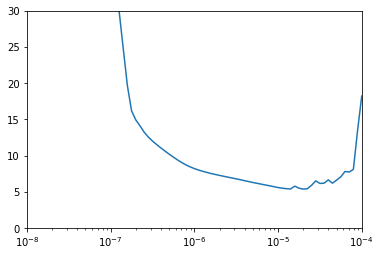

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [33]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)


seq2seq_window_dataset function
tf.Tensor(
[[ 52.48357077]
 [ 49.35275206]
 [ 53.31473872]
 [ 57.71182193]
 [ 48.93444534]
 [ 48.93124221]
 [ 57.98289687]
 [ 53.89712254]
 [ 47.67392616]
 [ 52.68370684]
 [ 47.59171581]
 [ 47.50637547]
 [ 50.95941456]
 [ 40.08618007]
 [ 40.91941291]
 [ 46.6124749 ]
 [ 44.2282075 ]
 [ 50.7206442 ]
 [ 44.45498265]
 [ 41.76799162]
 [ 55.98093655]
 [ 47.33583647]
 [ 48.60329748]
 [ 40.93184102]
 [ 45.11265791]
 [ 48.15731844]
 [ 41.60509948]
 [ 48.98523395]
 [ 43.83963141]
 [ 45.10993464]
 [ 43.27504251]
 [ 55.24983156]
 [ 45.61561472]
 [ 40.07910685]
 [ 49.15495543]
 [ 38.60270198]
 [ 45.40616172]
 [ 34.20876785]
 [ 37.00193411]
 [ 44.25351033]
 [ 46.57859628]
 [ 43.35101175]
 [ 41.51481464]
 [ 40.17753568]
 [ 33.87169104]
 [ 37.2377144 ]
 [ 38.09790511]
 [ 45.24254666]
 [ 41.22268301]
 [ 30.22901514]
 [ 40.19637968]
 [ 36.17456548]
 [ 34.23181292]
 [ 40.18383749]
 [ 41.78223419]
 [ 40.77832754]
 [ 31.41360409]
 [ 33.54463559]
 [ 36.22142998]
 [ 38.9108339

In [32]:
print(train_set)
print(valid_set)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>


In [ ]:

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

In [8]:
model = keras.models.load_model("my_checkpoint.h5")

In [9]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

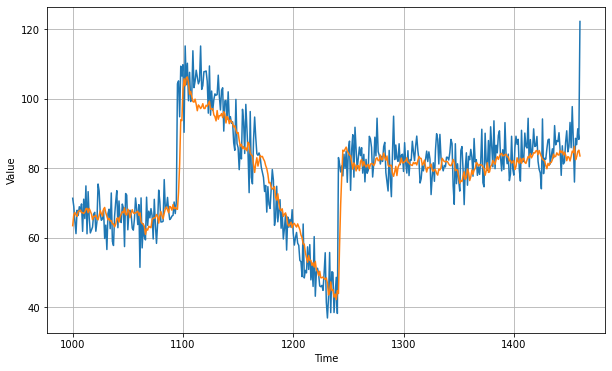

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [11]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.112614

## Fully Convolutional Forecasting

In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/100
8/8 [==============================] - 0s 36ms/step - loss: 42.2341 - mae: 42.7330
Epoch 2/100
8/8 [==============================] - 0s 36ms/step - loss: 41.8293 - mae: 42.3284
Epoch 3/100
8/8 [==============================] - 0s 38ms/step - loss: 41.4367 - mae: 41.9357
Epoch 4/100
8/8 [==============================] - 0s 35ms/step - loss: 41.0108 - mae: 41.5098
Epoch 5/100
8/8 [===

(0.0001, 0.1, 0.0, 30.0)

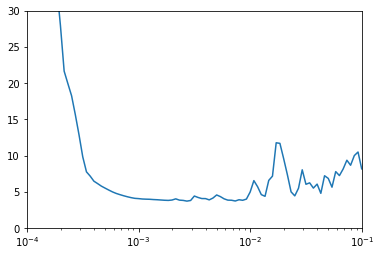

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [15]:
model = keras.models.load_model("my_checkpoint.h5")

In [16]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

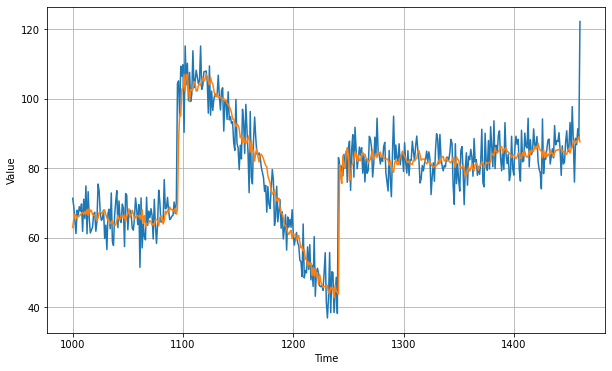

In [17]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [18]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.5292606